In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import csv
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
np.random.seed(1234)

Using TensorFlow backend.


In [4]:
def data_power_consumption(path_to_dataset, sequence_length=50, ratio=1.0):

    max_values = ratio * 2049280

    with open(path_to_dataset) as f:
        data = csv.reader(f, delimiter=";")
        power = []
        nb_of_values = 0
        for line in data:
            try:
                power.append(float(line[2]))
                nb_of_values += 1
            except ValueError:
                pass
            # 2049280.0 is the total number of valid values, i.e. ratio = 1.0
            if nb_of_values >= max_values:
                break

    print("Data loaded from csv. Formatting...")

    result = []
    for index in range(len(power) - sequence_length):
        result.append(power[index: index + sequence_length])
    result = np.array(result)  # shape (2049230, 50)

    result_mean = result.mean()
    result -= result_mean
    print("Shift : ", result_mean)
    print("Data  : ", result.shape)

    row = int(round(0.9 * result.shape[0]))
    train = result[:row, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = result[row:, :-1]
    y_test = result[row:, -1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return [X_train, y_train, X_test, y_test]

In [5]:
def build_model():
    model = Sequential()
    layers = [1, 50, 100, 1]

    model.add(LSTM(layers[1], input_shape=(None, layers[0]), return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(layers[2], return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("Compilation Time : ", time.time() - start)
    return model

In [9]:
def run_network(model=None, data=None):
    global_start_time = time.time()
    epochs = 1
    ratio = 0.5
    sequence_length = 50
    path_to_dataset = 'data/household_power_consumption.txt'

    if data is None:
        print('Loading data... ')
        X_train, y_train, X_test, y_test = data_power_consumption(
            path_to_dataset, sequence_length, ratio)
    else:
        X_train, y_train, X_test, y_test = data

    print('\nData Loaded. Compiling...\n')

    if model is None:
        model = build_model()

    try:
        model.fit(
            X_train, y_train,
            batch_size=512, nb_epoch=epochs, validation_split=0.05)
        predicted = model.predict(X_test)
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("Training duration (s) : ", time.time() - global_start_time)
        return model, y_test, 0

    try:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(y_test[:100])
        plt.plot(predicted[:100])
        plt.show()
    except Exception as e:
        print(str(e))
    print("Training duration (s) : ", time.time() - global_start_time)
    
    return model, y_test, predicted

Loading data... 
Data loaded from csv. Formatting...
Shift :  1.10309644346
Data  :  (1024590, 50)

Data Loaded. Compiling...

Compilation Time :  0.02740192413330078


/Users/anindyas/anaconda/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 876024 samples, validate on 46107 samples
Epoch 1/1
876024/876024 [==============================] - 1394s - loss: 0.1003 - val_loss: 0.0772


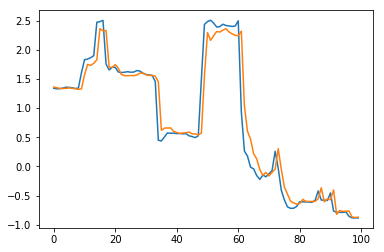

Training duration (s) :  1525.0693786144257


In [10]:
if __name__ == '__main__':
    run_network()